# Data preprocessing

## Compute the consumption by hour

In [2]:
import pandas as pd
from pathlib import Path
from pprint import pprint
from datetime import datetime, timedelta # to convert timestamp/ID to human readable format
from tqdm import tqdm

In [3]:
'''
# load CSV files
raw_data = Path('../rawdata')
tables = {}
for i, file in enumerate(raw_data.iterdir()):
    name = file.name.split('.')[0]
    tables[f"{name}"] = pd.read_csv(f"../rawdata/{file.name}", header = None, names=('ID', name))
'''

'\n# load CSV files\nraw_data = Path(\'../rawdata\')\ntables = {}\nfor i, file in enumerate(raw_data.iterdir()):\n    name = file.name.split(\'.\')[0]\n    tables[f"{name}"] = pd.read_csv(f"../rawdata/{file.name}", header = None, names=(\'ID\', name))\n'

## Date transformation functions

In [3]:
def ticks_to_iso(ticks):
    """Convert .NET DateTime.Ticks to an ISO 8601 formatted string."""
    ticks_epoch = datetime(1, 1, 1)  # .NET starts from year 0001-01-01
    date_time = ticks_epoch + timedelta(microseconds=ticks / 10)  # Convert ticks to microseconds
    return date_time.isoformat()

def ticks_to_ymd(ticks):
    """Convert .NET DateTime.Ticks to an ISO 8601 formatted string."""
    ticks_epoch = datetime(1, 1, 1)  # .NET starts from year 0001-01-01
    date_time = ticks_epoch + timedelta(microseconds=ticks / 10)  # Convert ticks to microseconds
    return date_time.strftime("%Y-%m-%d")

In [5]:
# Join fuelDensity and fuelVolumeFlowRate
df_density = pd.read_csv("../rawdata/fuelDensity.csv", header = None, names=('ID', 'fuelDensity'))
df_volFlow = pd.read_csv("../rawdata/fuelVolumeFlowRate.csv", header = None, names=('ID', 'fuelVolumeFlowRate'))
df_fuel = df_density.merge(df_volFlow, on='ID')

# 1) Add date, hour cloumns and fuelMassFlowRate
df_fuel["iso_date"] = df_fuel.ID.apply(ticks_to_iso)
df_fuel["dateHour"] = df_fuel.ID.apply(lambda x: ticks_to_iso(x)[:13])
df_fuel["fuelMassFlowRate"] = df_fuel.fuelDensity * df_fuel.fuelVolumeFlowRate

# 2) drop unecessary cols
df_fuel = df_fuel.drop('ID', axis=1)
df_fuel = df_fuel.drop(["fuelDensity","fuelVolumeFlowRate"], axis=1)

# TIMEDIFF

# 3) Change iso_date type to timestamp in order to compute time differences
df_fuel["iso_date"] = pd.to_datetime(df_fuel["iso_date"], format='ISO8601')

# 4) Drop lines where fuel flow is 0, IMPORTANT
#    time diffs must be calculated only for the engine runtime
#    or maybe I can skip that, at least I will have 0 consumption per hour in training dataset
df_fuel = df_fuel[df_fuel["fuelMassFlowRate"] != 0]

# 5) Add time diff
df_fuel["timeDiff"] = df_fuel.iso_date.diff()

# 6) Fill border line with 0 (only a small error)
df_fuel.timeDiff = df_fuel.timeDiff.fillna(pd.Timedelta(seconds=0))

# 7) Despite the efort to count make diffs only from runtime some non-sense timediffs occured.
#    Therefore I am going to filter them out. Sampling frequency was around 1.02 s
df_fuel = df_fuel[df_fuel["timeDiff"].dt.total_seconds() < 1.2]

# Compute fuel consumption for every interval
df_fuel["fuelMassConsumption"] = df_fuel.fuelMassFlowRate * df_fuel.timeDiff.dt.total_seconds()
df_fuel

,iso_date,dateHour,fuelMassFlowRate,timeDiff,fuelMassConsumption
4,2010-02-16 12:48:13.560688,2010-02-16T12,0.266306,0 days 00:00:00,0.000000
5,2010-02-16 12:48:14.582064,2010-02-16T12,0.261940,0 days 00:00:01.021376,0.267539
6,2010-02-16 12:48:15.603488,2010-02-16T12,0.265296,0 days 00:00:01.021424,0.270979
7,2010-02-16 12:48:16.626888,2010-02-16T12,0.263480,0 days 00:00:01.023400,0.269645
8,2010-02-16 12:48:17.649280,2010-02-16T12,0.262434,0 days 00:00:01.022392,0.268311
...,...,...,...,...,...
1627319,2010-04-12 22:25:12.142864,2010-04-12T22,0.189356,0 days 00:00:01.023416,0.193790
1627320,2010-04-12 22:25:13.164264,2010-04-12T22,0.190873,0 days 00:00:01.021400,0.194958
1627321,2010-04-12 22:25:14.186664,2010-04-12T22,0.197969,0 days 00:00:01.022400,0.202404
1627322,2010-04-12 22:25:15.208072,2010-04-12T22,0.208952,0 days 00:00:01.021408,0.213426


In [6]:
df_daily_consumption = df_fuel[["dateHour","fuelMassConsumption"]].groupby("dateHour").sum().apply(lambda x: x*0.001)


In [7]:
display(df_daily_consumption)
display(df_daily_consumption.info())
display(df_daily_consumption.describe())

,fuelMassConsumption
dateHour,
2010-02-16T12,0.309810
2010-02-16T13,1.672615
2010-02-16T14,1.663355
2010-02-16T15,0.329521
2010-02-17T06,0.520858
...,...
2010-04-12T18,1.772452
2010-04-12T19,1.901760
2010-04-12T20,0.596245


<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 2010-02-16T12 to 2010-04-12T22
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fuelMassConsumption  682 non-null    float64
dtypes: float64(1)
memory usage: 10.7+ KB


None

,fuelMassConsumption
count,682.000000
mean,1.330281
std,0.686605
min,0.003561
25%,0.675496
50%,1.486395
75%,2.013399
max,2.312076


In [8]:
df_fuel.describe()

,iso_date,fuelMassFlowRate,timeDiff,fuelMassConsumption
count,1626840,1.626840e+06,1626840,1.626840e+06
mean,2010-03-16 06:06:46.706343168,5.455613e-01,0 days 00:00:01.022207642,5.576771e-01
min,2010-02-16 12:48:13.560688,2.159260e-02,0 days 00:00:00,0.000000e+00
25%,2010-03-02 13:38:17.303463936,5.443790e-01,0 days 00:00:01.021376,5.564628e-01
50%,2010-03-15 21:02:59.776580096,5.801077e-01,0 days 00:00:01.022344,5.929853e-01
75%,2010-03-29 07:13:28.987108096,6.053773e-01,0 days 00:00:01.022432,6.188304e-01
max,2010-04-12 22:25:16.230472,8.806616e-01,0 days 00:00:01.056008,9.074478e-01
std,NaN,1.102407e-01,0 days 00:00:00.001420576,1.126915e-01


In [9]:
# df_daily_consumption.to_csv('../processed_data/daily_consumption.csv',header=True, , index=False)

# Feature extraction

In [4]:
def transform_feature(csvFile):
    feature_name = csvFile.split('/')[2].split('.')[0]
    df = pd.read_csv(csvFile, names=['iso_date', feature_name])
    df["date"] = df.iso_date.apply(ticks_to_ymd)
    df["iso_date"] = df.iso_date.apply(ticks_to_iso)
    df["dateHour"] = df.iso_date.apply(lambda x: x[:13])
    return df

In [5]:
def lost_hours(df_aggre, df_toMerge):
    n_0 = df_aggre.shape[0]
    n_1 = df_aggre.merge(df_toMerge, on='dateHour').shape[0]
    return abs(n_0 - n_1)

## GPS
To somehow to represent GPS information in numerical value, I will perform following transformation of signs:
(North ... +, South ... -, East ... -, West ... +)

In [6]:
def transform_gps(val):
    match val[-1]:
        case 'W':
            val = float(val[:-1])
        case 'E':
            val = float(val[:-1]) * (-1)
        case 'N':
            val = float(val[:-1])
        case 'S':
            val = float(val[:-1]) * (-1)
    return val

# Create dataset

In [7]:
def create_dataset(feature_name):
        df = transform_feature(f"../rawdata/{feature_name}.csv")
        # transform GPS
        if feature_name in ("longitude", "latitude"):
            # transform to numeric
            df[feature_name] = df[feature_name].apply(transform_gps)
            # get extreme values
            df_min = df[['dateHour',feature_name]].groupby('dateHour').min()
            df_max = df[['dateHour',feature_name]].groupby('dateHour').max()
            # group exremes in df
            df_toMerge = df_max.merge(df_min, on='dateHour', suffixes=('_max','_min'))
            
        #all other features
        else:
            # calculate AVG value per hour
            df_toMerge = df[["dateHour",feature_name]].groupby("dateHour").mean()
        return df_toMerge

In [14]:
data = [
    'starboardRudder',
     'portPitch',
     'level2median',
     'latitude',
     'speedKnots',
     'longitudinalWaterSpeed',
     'trackDegreeTrue',
     'windSpeed',
     'trueHeading',
     'starboardPitch',
     'portRudder',
     'longitude',
     'level1median',
     'trackDegreeMagnetic',
     'inclinometer-raw',
     'windAngle',
     'speedKmh',
     'fuelTemp'
    ]

In [15]:
df_total = pd.read_csv('../processed_data/daily_consumption.csv')
for file in tqdm(data):
    df_inter = create_dataset(file)
    df_total = df_total.merge(df_inter, on='dateHour')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [05:23<00:00, 17.95s/it]


In [16]:
df_total.describe()
df_total.shape

(682, 22)

In [17]:
# df_total.to_csv('../processed_data/proto_dataset.csv',header=True, index=False)

### Traveled distance per hour

In [10]:
def dmm_to_dd(dmm):
    degrees = int(dmm[:2])  # First two digits are degrees
    minutes = float(dmm[2:])  # Remaining are minutes
    decimal_degrees = degrees + (minutes / 60)

    return decimal_degrees

In [37]:
df_total = pd.read_csv('../processed_data/proto_dataset.csv')
df_total["latitude_max"] = df_total.latitude_max.apply(lambda x: dmm_to_dd(str(x)))
df_total["latitude_min"] = df_total.latitude_min.apply(lambda x: dmm_to_dd(str(x)))
df_total["longitude_max"] = df_total.longitude_max.apply(lambda x: dmm_to_dd(str(x)))
df_total["longitude_min"] = df_total.longitude_min.apply(lambda x: dmm_to_dd(str(x)))
df_total

,Unnamed: 0,dateHour,fuelMassConsumption,starboardRudder,portPitch,level2median,latitude_max,latitude_min,speedKnots,longitudinalWaterSpeed,...,starboardPitch,portRudder,longitude_max,longitude_min,level1median,trackDegreeMagnetic,inclinometer-raw,windAngle,speedKmh,fuelTemp
0,0,2010-02-16T12,0.309810,0.073891,5.747796,14.203450,62.007168,61.968700,15.024862,13.678667,...,7.078122,-0.277101,64.102405,64.047648,17.178958,163.902905,357.345570,285.118644,27.826796,92.897298
1,1,2010-02-16T13,1.672615,-0.125639,6.942320,14.458455,61.968608,61.765038,19.365727,18.157968,...,8.181388,-0.106311,65.144142,64.044052,17.043781,211.851817,357.232369,216.812222,35.861903,97.423365
2,2,2010-02-16T14,1.663355,-0.211416,6.588657,14.075201,61.764960,61.535452,15.843385,16.765092,...,7.872375,-0.192681,65.061297,64.037038,16.891017,167.423309,357.258047,298.276111,29.342679,98.076956
3,3,2010-02-16T15,0.329521,1.364343,3.935095,14.419810,61.551183,61.533773,11.918610,11.124915,...,4.023595,-1.789312,64.153943,64.064548,16.764338,260.103957,357.217410,133.550000,22.068770,98.096868
4,4,2010-02-17T06,0.520858,-0.257127,7.390354,14.348569,61.551740,61.532692,15.650000,15.162706,...,7.094899,-0.247239,64.153033,64.045107,16.953088,119.086228,357.373717,295.705882,28.985421,93.309810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,677,2010-04-12T18,1.772452,-0.124941,8.281447,14.660129,61.739960,61.532470,19.705166,18.835669,...,8.196086,-0.109072,64.152897,63.081660,16.681704,52.822548,357.320882,299.600135,36.499605,96.677519
678,678,2010-04-12T19,1.901760,0.369780,7.447542,14.902331,62.007203,61.740060,18.495887,17.545588,...,7.014589,-0.808822,64.102553,63.076775,16.540197,230.114482,357.289223,204.543174,34.252585,97.491246
679,679,2010-04-12T20,0.596245,0.306127,6.920700,14.789374,62.007178,61.932830,16.599298,15.773654,...,7.226793,-0.119723,64.102475,64.030793,16.503594,171.170035,357.324167,149.544964,30.737928,96.052600
680,680,2010-04-12T21,2.176730,-0.049906,8.561014,14.937905,61.932735,61.587108,21.537955,20.078128,...,8.490021,-0.037657,64.030717,63.116842,16.432261,186.943296,357.248400,133.412222,39.888309,97.628750


In [15]:
import math

def calc_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of Earth in kilometers.
    r = 6378  
    return c * r

In [38]:
df_total["distance"] = df_total.apply(lambda row: calc_distance(row['latitude_min'], row['longitude_min'], row['latitude_max'], row['longitude_max']), axis=1)
df_total

,Unnamed: 0,dateHour,fuelMassConsumption,starboardRudder,portPitch,level2median,latitude_max,latitude_min,speedKnots,longitudinalWaterSpeed,...,portRudder,longitude_max,longitude_min,level1median,trackDegreeMagnetic,inclinometer-raw,windAngle,speedKmh,fuelTemp,distance
0,0,2010-02-16T12,0.309810,0.073891,5.747796,14.203450,62.007168,61.968700,15.024862,13.678667,...,-0.277101,64.102405,64.047648,17.178958,163.902905,357.345570,285.118644,27.826796,92.897298,5.150952
1,1,2010-02-16T13,1.672615,-0.125639,6.942320,14.458455,61.968608,61.765038,19.365727,18.157968,...,-0.106311,65.144142,64.044052,17.043781,211.851817,357.232369,216.812222,35.861903,97.423365,62.028570
2,2,2010-02-16T14,1.663355,-0.211416,6.588657,14.075201,61.764960,61.535452,15.843385,16.765092,...,-0.192681,65.061297,64.037038,16.891017,167.423309,357.258047,298.276111,29.342679,98.076956,59.865805
3,3,2010-02-16T15,0.329521,1.364343,3.935095,14.419810,61.551183,61.533773,11.918610,11.124915,...,-1.789312,64.153943,64.064548,16.764338,260.103957,357.217410,133.550000,22.068770,98.096868,5.122573
4,4,2010-02-17T06,0.520858,-0.257127,7.390354,14.348569,61.551740,61.532692,15.650000,15.162706,...,-0.247239,64.153033,64.045107,16.953088,119.086228,357.373717,295.705882,28.985421,93.309810,6.104912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,677,2010-04-12T18,1.772452,-0.124941,8.281447,14.660129,61.739960,61.532470,19.705166,18.835669,...,-0.109072,64.152897,63.081660,16.681704,52.822548,357.320882,299.600135,36.499605,96.677519,61.177111
678,678,2010-04-12T19,1.901760,0.369780,7.447542,14.902331,62.007203,61.740060,18.495887,17.545588,...,-0.808822,64.102553,63.076775,16.540197,230.114482,357.289223,204.543174,34.252585,97.491246,61.496621
679,679,2010-04-12T20,0.596245,0.306127,6.920700,14.789374,62.007178,61.932830,16.599298,15.773654,...,-0.119723,64.102475,64.030793,16.503594,171.170035,357.324167,149.544964,30.737928,96.052600,9.086091
680,680,2010-04-12T21,2.176730,-0.049906,8.561014,14.937905,61.932735,61.587108,21.537955,20.078128,...,-0.037657,64.030717,63.116842,16.432261,186.943296,357.248400,133.412222,39.888309,97.628750,61.620978


In [39]:
df_total = df_total.drop(['longitude_max','longitude_min','latitude_max','latitude_min','Unnamed: 0'], axis=1)

In [41]:
df_total.to_csv('../processed_data/final_dataset.csv',index=False)

## Division and scaling

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ParameterGrid

In [43]:
df_total = pd.read_csv('../processed_data/final_dataset.csv')
df_total

,dateHour,fuelMassConsumption,starboardRudder,portPitch,level2median,speedKnots,longitudinalWaterSpeed,trackDegreeTrue,windSpeed,trueHeading,starboardPitch,portRudder,level1median,trackDegreeMagnetic,inclinometer-raw,windAngle,speedKmh,fuelTemp,distance
0,2010-02-16T12,0.309810,0.073891,5.747796,14.203450,15.024862,13.678667,156.702905,20.444633,162.164754,7.078122,-0.277101,17.178958,163.902905,357.345570,285.118644,27.826796,92.897298,5.150952
1,2010-02-16T13,1.672615,-0.125639,6.942320,14.458455,19.365727,18.157968,204.731508,13.689500,215.339870,8.181388,-0.106311,17.043781,211.851817,357.232369,216.812222,35.861903,97.423365,62.028570
2,2010-02-16T14,1.663355,-0.211416,6.588657,14.075201,15.843385,16.765092,160.323309,17.630444,169.736120,7.872375,-0.192681,16.891017,167.423309,357.258047,298.276111,29.342679,98.076956,59.865805
3,2010-02-16T15,0.329521,1.364343,3.935095,14.419810,11.918610,11.124915,253.026203,5.682391,294.527236,4.023595,-1.789312,16.764338,260.103957,357.217410,133.550000,22.068770,98.096868,5.122573
4,2010-02-17T06,0.520858,-0.257127,7.390354,14.348569,15.650000,15.162706,114.306166,17.925840,109.823715,7.094899,-0.247239,16.953088,119.086228,357.373717,295.705882,28.985421,93.309810,6.104912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,2010-04-12T18,1.772452,-0.124941,8.281447,14.660129,19.705166,18.835669,46.296544,12.832097,37.347123,8.196086,-0.109072,16.681704,52.822548,357.320882,299.600135,36.499605,96.677519,61.177111
678,2010-04-12T19,1.901760,0.369780,7.447542,14.902331,18.495887,17.545588,286.618709,14.718145,235.080648,7.014589,-0.808822,16.540197,230.114482,357.289223,204.543174,34.252585,97.491246,61.496621
679,2010-04-12T20,0.596245,0.306127,6.920700,14.789374,16.599298,15.773654,163.970035,6.905036,173.477314,7.226793,-0.119723,16.503594,171.170035,357.324167,149.544964,30.737928,96.052600,9.086091
680,2010-04-12T21,2.176730,-0.049906,8.561014,14.937905,21.537955,20.078128,179.835654,10.052778,187.343283,8.490021,-0.037657,16.432261,186.943296,357.248400,133.412222,39.888309,97.628750,61.620978


### Spliting data

In [44]:
# To test non-random test split for time series data
Xdata = df_total.drop("fuelMassConsumption", axis = 1)

# Xdata = df_total.drop(["fuelMassConsumption", "dateHour"], axis = 1)
ydata = df_total["fuelMassConsumption"]

rd_seed = 42

# Keeping subsets chronological helps to validation and testing statistics more relevant towards use on new data.
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.3, shuffle=False)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, shuffle=False)

display(Xtrain.shape)
display(ytrain.shape)
display(Xval.shape)
display(yval.shape)
display(Xtest.shape)
display(ytest.shape)

(477, 18)

(477,)

(102, 18)

(102,)

(103, 18)

(103,)

In [45]:
# Check if data are in ascending order
print(f'Xtrain dateHour min: {Xtrain.dateHour.min()}, max: {Xtrain.dateHour.max()}')
print(f'Xval dateHour min: {Xval.dateHour.min()}, max: {Xval.dateHour.max()}')
print(f'Xtest dateHour min: {Xtest.dateHour.min()}, max: {Xtest.dateHour.max()}')

Xtrain dateHour min: 2010-02-16T12, max: 2010-03-26T08
Xval dateHour min: 2010-03-26T12, max: 2010-04-05T08
Xtest dateHour min: 2010-04-05T09, max: 2010-04-12T22


In [46]:
Xtrain = Xtrain.drop("dateHour", axis=1)
Xval = Xval.drop("dateHour", axis=1)
Xtest = Xtest.drop("dateHour", axis=1)

### Scaling

In [47]:
scaler = StandardScaler()
Xtrain_st = scaler.fit_transform(Xtrain)
Xval_st = scaler.transform(Xval)
Xtest_st = scaler.transform(Xtest)

In [48]:
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

# Model selection

## Ridge regresion
Linear model is the simplest one, therefore it can be a good starting point. And slight regularisation should be also useful.

In [49]:
def train_ridge_alpha(begin, end, mode='visual'):
    alphas = np.linspace(begin, end, 50)
    RMSE = {}
    for alpha in alphas:
        clf_Ridge = Ridge(alpha = alpha)
        clf_Ridge.fit(Xtrain_st, ytrain)
        rmse = root_mean_squared_error(yval, clf_Ridge.predict(Xval_st))
        r2 = r2_score(yval, clf_Ridge.predict(Xval_st))
        RMSE[rmse] = [alpha, r2]
    if mode =='visual':
            plt.plot(alphas, RMSE.keys(), '.')
            plt.title('Ridge regression validation RMSE as function of alpha')
            plt.xlabel("Alpha")
            plt.ylabel("RMSE")   
            plt.show()
    elif mode == 'png':
            plt.plot(alphas, RMSE.keys(), '.')
            plt.title('Ridge regression validation RMSE as function of alpha')
            plt.xlabel("Alpha")
            plt.ylabel("RMSE")
            plt.savefig('../pictures/ridge_training.png')
    return alphas, RMSE

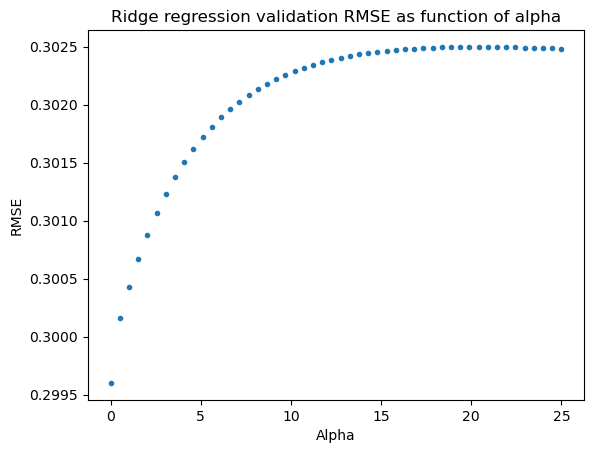

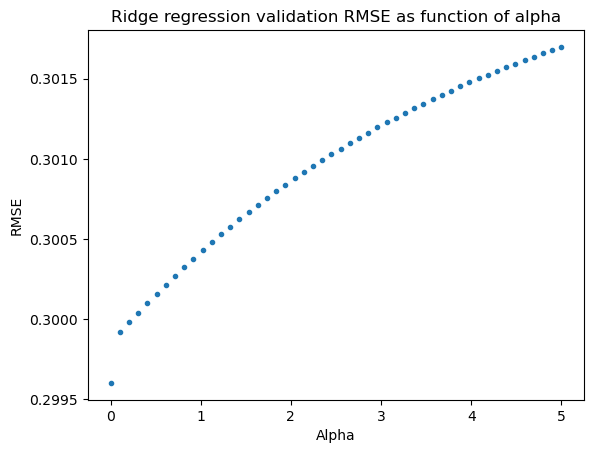

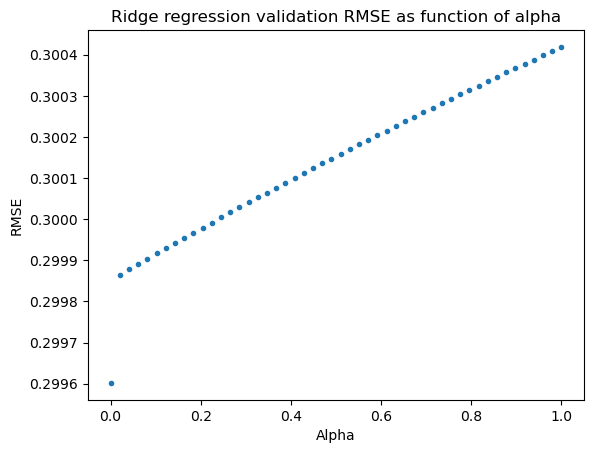

In [68]:
aplhas1, ridgeRMSE1 = train_ridge_alpha(0,25)

alphas2, ridgeRMSE2 = train_ridge_alpha(0,5)

alphas3, ridgeRMSE3 = train_ridge_alpha(0,1)

In [77]:
print('Mean val consumption: ',yval.mean())
best_RMSE_ridge =  min(ridgeRMSE3.keys())
print('Best RMSE ridge:', best_RMSE_ridge)
opt_alpha = ridgeRMSE3[best_RMSE_ridge][0]
print(f'Optimal value of alpha: {opt_alpha}')
best_R2_ridge = ridgeRMSE3[best_RMSE_ridge][1]
print('Best R2 SVM:', best_R2_ridge)
print(f'Best rel. RMSE {((best_RMSE_ridge/yval.mean())*0.01):.4f} %')

Mean val consumption:  1.413138228357714
Best RMSE ridge: 0.2996018823682273
Optimal value of alpha: 0.0
Best R2 SVM: 0.7850011819405739
Best rel. RMSE 0.0021 %


## SVM
Now let's try SMV in order to introduce non-linearity.

In [52]:
from sklearn.svm import SVR

In [53]:
def train_SVR_C(begin, end, mode='visual', zoom=1):
    Cs = [i/zoom for i in range(begin, end)]
    RMSE = {}
    for c in Cs:
        clf = SVR(kernel = 'rbf',C = c)
        clf.fit(Xtrain_scaled, ytrain)
        ypred = clf.predict(Xval_scaled)
        rmse = root_mean_squared_error(yval, ypred)
        r2 = r2_score(yval, ypred)
        RMSE[rmse] = [c, r2]
    if mode =='visual':
            plt.plot(Cs, RMSE.keys(), '.')
            plt.title('SVR RMSE as function of regularisation parameter C')
            plt.xlabel("C")
            plt.ylabel("RMSE")   
            plt.show()
    elif mode == 'png':
            plt.plot(Cs, RMSE.keys(), '.')
            plt.title('SVR validation RMSE as function of regularisation parameter C')
            plt.xlabel("C")
            plt.ylabel("RMSE")
            plt.savefig('../pictures/SVR_training.png')
    return Cs, RMSE

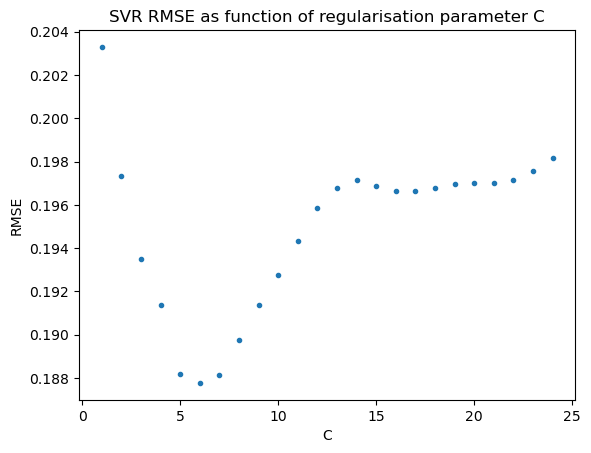

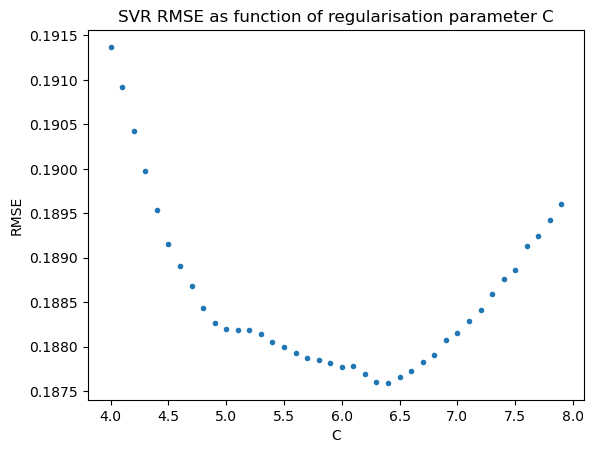

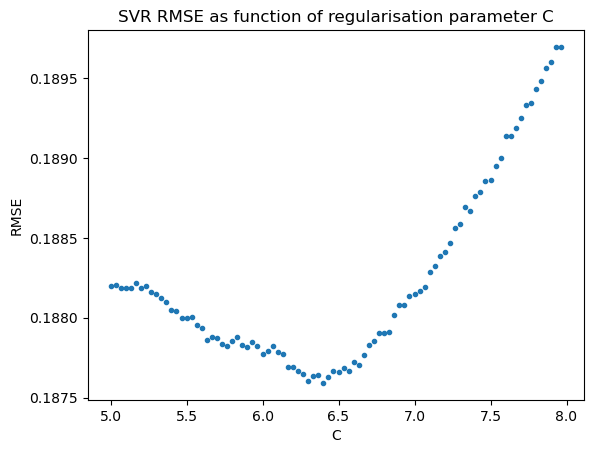

In [64]:
Cs1, svmRMSE1 = train_SVR_C(1,25)
Cs2, svmRMSE2 = train_SVR_C(40,80, zoom=10)
Cs3, svmRMSE3 = train_SVR_C(150,240, zoom=30)

In [65]:
print('Mean val consumption: ',yval.mean())
best_RMSE_SVM =  min(svmRMSE3.keys())
print('Best RMSE SVM:', best_RMSE_SVM)
opt_C = svmRMSE3[best_RMSE_SVM][0]
print(f'Optimal value of C: {opt_C}')
best_R2_SVM = svmRMSE3[best_RMSE_SVM][1]
print('Best R2 SVM:', best_R2_SVM)
print(f'Best rel. RMSE {((best_RMSE_SVM/yval.mean())*0.01):.4f} %')

Mean val consumption:  1.413138228357714
Best RMSE SVM: 0.18759189933567144
Optimal value of C: 6.4
Best R2 SVM: 0.9157101738196957
Best rel. RMSE 0.0013 %


### SVM + PCA

In [78]:
from sklearn.decomposition import PCA

pca = PCA()
Xtrain_pca = pca.fit_transform(Xtrain_scaled)
Xval_pca = pca.transform(Xval_scaled)

In [80]:
print(pca.explained_variance_ratio_.sum())
print("N_components = ",len(pca.explained_variance_ratio_))
for i in range(0, len(pca.explained_variance_ratio_)):
    print(f"{pca.explained_variance_ratio_[0:i].sum()*100}% explain by first {i} components")

1.0
N_components =  17
0.0% explain by first 0 components
44.623881440520194% explain by first 1 components
65.98295085711706% explain by first 2 components
78.1473100893724% explain by first 3 components
86.06744333861089% explain by first 4 components
90.5688765258553% explain by first 5 components
94.46983753673094% explain by first 6 components
96.27699973371804% explain by first 7 components
97.41290205068549% explain by first 8 components
98.29727997366705% explain by first 9 components
99.04755326310362% explain by first 10 components
99.4365497220489% explain by first 11 components
99.66353075955871% explain by first 12 components
99.82273357681528% explain by first 13 components
99.89988577880239% explain by first 14 components
99.96444936027031% explain by first 15 components
99.99999945400965% explain by first 16 components


In [86]:
clf_screen = SVR(C=opt_C, kernel="rbf")
clf_screen.fit(Xtrain_pca[:,0:10], ytrain)
print("RMSE :", root_mean_squared_error(yval, clf_screen.predict(Xval_pca[:,0:10])))
print("R2 :",r2_score(yval, clf_screen.predict(Xval_pca[:,0:10])))

RMSE : 0.18374453815745517
R2 : 0.9191321542542864


In [106]:
def train_SVR_PCA_C(begin, end, mode='visual', zoom=1, components = 10):
    Cs = [i/zoom for i in range(begin, end)]
    RMSE = {}
    for c in Cs:
        clf = SVR(kernel = 'rbf',C = c)
        clf.fit(Xtrain_pca[:,0:components], ytrain)
        ypred = clf.predict(Xval_pca[:,0:components])
        rmse = root_mean_squared_error(yval, ypred)
        r2 = r2_score(yval, ypred)
        RMSE[rmse] = [c, r2]
    if mode =='visual':
            plt.plot(Cs, RMSE.keys(), '.')
            plt.title('SVR RMSE as function of regularisation parameter C')
            plt.xlabel("C")
            plt.ylabel("RMSE")   
            plt.show()
    elif mode == 'png':
            plt.plot(Cs, RMSE.keys(), '.')
            plt.title('SVR validation RMSE as function of regularisation parameter C')
            plt.xlabel("C")
            plt.ylabel("RMSE")
            plt.savefig('../pictures/SVR_training.png')
    return Cs, RMSE

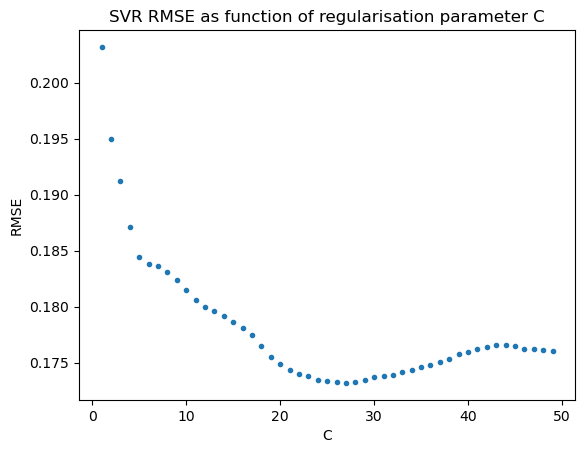

In [97]:
pcaCs1, pcasvmRMSE1 = train_SVR_PCA_C(1,50)

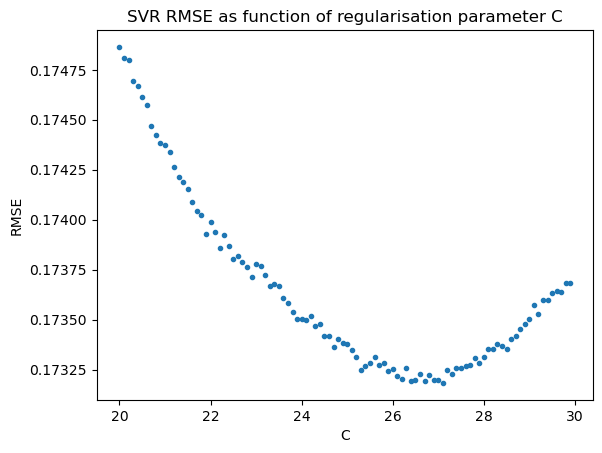

In [98]:
pcaCs2, pcasvmRMSE2 = train_SVR_PCA_C(200,300, zoom=10)

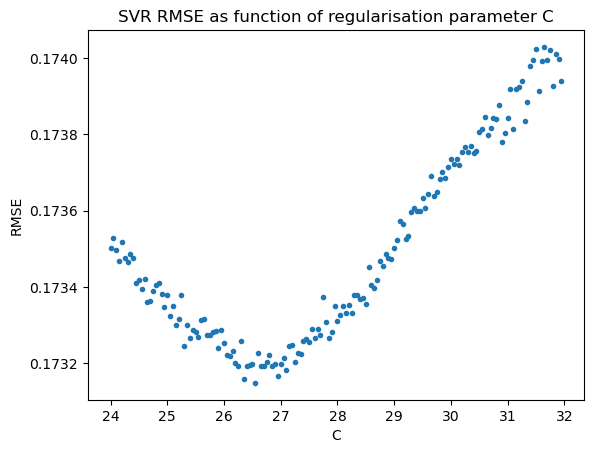

In [121]:
pcaCs3, pcasvmRMSE3 = train_SVR_PCA_C(480,640, zoom=20)

In [122]:
print('Mean val consumption: ',yval.mean())
best_RMSE_pca =  min(pcasvmRMSE3.keys())
print('Best RMSE SVM:', best_RMSE_pca)
opt_Cpca = pcasvmRMSE3[best_RMSE_pca][0]
print(f'Optimal value of C: {opt_Cpca}')
best_R2_pca = pcasvmRMSE3[best_RMSE_pca][1]
print('Best R2 SVM:', best_R2_pca)
print(f'Best rel. RMSE {((best_RMSE_pca/yval.mean())*0.01):.4f} %')

Mean val consumption:  1.413138228357714
Best RMSE SVM: 0.17314884487511722
Optimal value of C: 26.55
Best R2 SVM: 0.9281897904117445
Best rel. RMSE 0.0012 %


#### Tune number of components

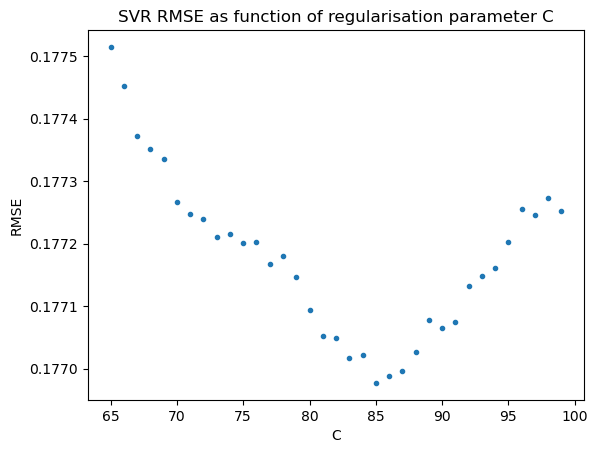

In [117]:
pcaCs1, pcasvmRMSE1 = train_SVR_PCA_C(65,100,components=11)

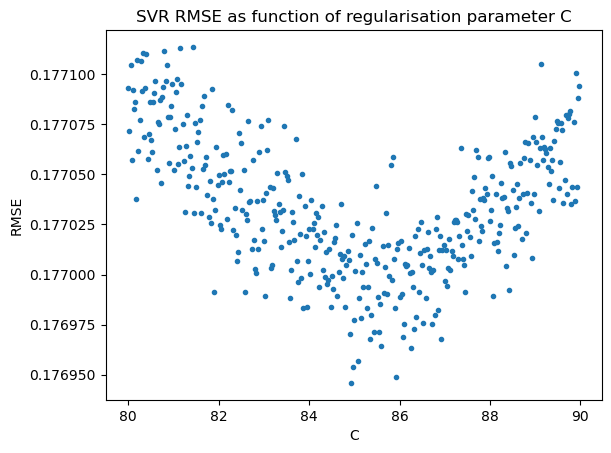

In [119]:
pcaCs3, pcasvmRMSE3 = train_SVR_PCA_C(3200,3600,zoom=40,components=11)

In [120]:
print('Mean val consumption: ',yval.mean())
best_RMSE_pca =  min(pcasvmRMSE3.keys())
print('Best RMSE SVM:', best_RMSE_pca)
opt_Cpca = pcasvmRMSE3[best_RMSE_pca][0]
print(f'Optimal value of C: {opt_Cpca}')
best_R2_pca = pcasvmRMSE3[best_RMSE_pca][1]
print('Best R2 SVM:', best_R2_pca)
print(f'Best rel. RMSE {((best_RMSE_pca/yval.mean())*0.01):.4f} %')

Mean val consumption:  1.413138228357714
Best RMSE SVM: 0.17694579506047184
Optimal value of C: 84.925
Best R2 SVM: 0.9250058322076897
Best rel. RMSE 0.0013 %


# Model evaluation

In [124]:
final_model = SVR(C=26.55, kernel="rbf")
final_model.fit(Xtrain_scaled[:,:10], ytrain)
finalRMSE = root_mean_squared_error(yval, final_model.predict(Xval_scaled[:,:10]))
finalR2 = r2_score(ytest, final_model.predict(Xtest_scaled[:,:10]))
print(f'SVR test RMSE: {finalRMSE:.4f}')
print(f'SVR test R2: {finalR2:.4f}')

SVR test RMSE: 0.2017
SVR test R2: 0.8616


# Supporting materials

In [57]:
# alphas3, ridgeRMSE3= train_ridge_alpha(14,16, mode='png')

In [58]:
# Cs3, svmRMSE3 = train_SVR_C(270,330, zoom=30, mode='png')